In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import math
from datetime import date
from collections import Counter

# RQ1: Exploratory Data Analysis (EDA)

### Reviewing Sample Dataset

Using chunks to efficiently load data.

In [21]:
chunk_size = 100000
data = pd.read_csv("steam_reviews.csv", chunksize = chunk_size)

In [22]:
list_of_dataframes = []

for chunk in data:
    
    list_of_dataframes.append(chunk)
    
df = pd.concat(list_of_dataframes, ignore_index=True)

Initially we will be exploring a random sample of 25% of the whole dataset to improve efficiency.

In [23]:
sampledf = df.sample(frac=0.25, replace=False, random_state=0, ignore_index=True)
del df

In [24]:
sampledf.columns

Index(['Unnamed: 0', 'app_id', 'app_name', 'review_id', 'language', 'review',
       'timestamp_created', 'timestamp_updated', 'recommended',
       'votes_helpful', 'votes_funny', 'weighted_vote_score', 'comment_count',
       'steam_purchase', 'received_for_free', 'written_during_early_access',
       'author.steamid', 'author.num_games_owned', 'author.num_reviews',
       'author.playtime_forever', 'author.playtime_last_two_weeks',
       'author.playtime_at_review', 'author.last_played'],
      dtype='object')

Above are all the columns in the dataset. There are a few columns that look like they will not be very helpful for further data analysis, so they might be removed moving forward. Below are few of the rows displayed from our sampled dataset.

In [25]:
sampledf.head(5)

,Unnamed: 0,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,...,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
0,1295789,4000,Garry's Mod,34679964,english,So good,1504342783,1504342783,True,0,...,False,True,False,76561198354161895,8,1,105.0,0.0,105.0,1.504346e+09
1,17017541,323190,Frostpunk,41700224,schinese,唉，我国什么时候能有这种游戏呢,1524752413,1524752413,True,0,...,True,False,False,76561198236040324,93,33,777.0,0.0,240.0,1.600489e+09
2,9604080,391540,Undertale,42989790,english,This game is really good because it does a gre...,1529811251,1529811251,True,0,...,True,False,False,76561198124244599,69,3,1885.0,0.0,1226.0,1.529545e+09
3,8787014,1118200,People Playground,68537231,english,I love killing humans and making the gorse vio...,1588574301,1588574301,True,0,...,True,False,False,76561198841658648,84,10,17343.0,168.0,3268.0,1.610927e+09
4,11111137,238320,Outlast,54460240,english,"Played for 30 minutes, didn't get past a libra...",1564951234,1564951234,True,0,...,False,False,False,76561198296077229,151,3,30.0,0.0,30.0,1.523123e+09


Looking at the data, the `Unnamed: 0` column looks like it has index values so having a separate column for index values is not very useful for us, hence we will be dropping this column.

In [26]:
sampledf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5436843 entries, 0 to 5436842
Data columns (total 23 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   Unnamed: 0                      int64  
 1   app_id                          int64  
 2   app_name                        object 
 3   review_id                       int64  
 4   language                        object 
 5   review                          object 
 6   timestamp_created               int64  
 7   timestamp_updated               int64  
 8   recommended                     bool   
 9   votes_helpful                   int64  
 10  votes_funny                     int64  
 11  weighted_vote_score             float64
 12  comment_count                   int64  
 13  steam_purchase                  bool   
 14  received_for_free               bool   
 15  written_during_early_access     bool   
 16  author.steamid                  int64  
 17  author.num_games_owned     

The `timestamp_created` and `timestamp_updated` columns are of type `int64` and looking from the values they hold, the data seems to be in seconds. Moving forward, we will change the type to a timestamp. Moreover the **playtime** columns are of type `float64`, they might also be converted.

In [27]:
sampledf.describe()

,Unnamed: 0,app_id,review_id,timestamp_created,timestamp_updated,votes_helpful,votes_funny,weighted_vote_score,comment_count,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
count,5.436843e+06,5.436843e+06,5.436843e+06,5.436843e+06,5.436843e+06,5.436843e+06,5.436843e+06,5.436843e+06,5.436843e+06,5.436843e+06,5.436843e+06,5.436843e+06,5.436843e+06,5.436843e+06,5.430374e+06,5.436843e+06
mean,1.087211e+07,3.929540e+05,5.186580e+07,1.544409e+09,1.547538e+09,1.893670e+00,1.066474e+05,1.654941e-01,1.310003e-01,7.656120e+16,8.090668e+05,8.089444e+05,1.608210e+04,1.554397e+02,8.797576e+03,1.580478e+09
std,6.277302e+06,2.481702e+05,2.084386e+07,5.812869e+07,5.690294e+07,3.933494e+01,2.140169e+07,2.434342e-01,2.800617e+00,3.178345e+08,1.886194e+09,1.886194e+09,3.747497e+04,7.304198e+02,2.380213e+04,4.689043e+07
min,0.000000e+00,7.000000e+01,4.300000e+01,1.290198e+09,1.290198e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.656120e+16,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,5.436608e+06,2.427600e+05,3.637237e+07,1.510137e+09,1.511719e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.656120e+16,2.200000e+01,2.000000e+00,1.249000e+03,0.000000e+00,5.580000e+02,1.573318e+09
50%,1.086887e+07,3.595500e+05,5.383202e+07,1.562441e+09,1.572194e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.656120e+16,6.100000e+01,4.000000e+00,4.304000e+03,0.000000e+00,1.880000e+03,1.599030e+09
75%,1.630836e+07,5.780800e+05,6.927681e+07,1.589679e+09,1.591370e+09,1.000000e+00,0.000000e+00,4.827586e-01,0.000000e+00,7.656120e+16,1.460000e+02,1.000000e+01,1.489700e+04,0.000000e+00,6.812000e+03,1.608997e+09
max,2.174737e+07,1.291340e+06,8.521817e+07,1.611425e+09,2.227772e+09,1.992700e+04,4.294967e+09,9.940375e-01,4.893000e+03,7.656120e+16,4.398047e+12,4.398047e+12,3.345621e+06,2.600200e+04,3.062784e+06,1.611433e+09


In [28]:
sampledf.nunique()

Unnamed: 0                        5436843
app_id                                315
app_name                              315
review_id                         5428343
language                               28
review                            4328417
timestamp_created                 5220223
timestamp_updated                 5200477
recommended                             2
votes_helpful                        1608
votes_funny                          1252
weighted_vote_score                404116
comment_count                         218
steam_purchase                          2
received_for_free                       2
written_during_early_access             2
author.steamid                    4339108
author.num_games_owned               5546
author.num_reviews                    884
author.playtime_forever            193719
author.playtime_last_two_weeks      12731
author.playtime_at_review          141316
author.last_played                4883131
dtype: int64

In [29]:
sampledf.isna().sum()

Unnamed: 0                           0
app_id                               0
app_name                             0
review_id                            0
language                             0
review                            8443
timestamp_created                    0
timestamp_updated                    0
recommended                          0
votes_helpful                        0
votes_funny                          0
weighted_vote_score                  0
comment_count                        0
steam_purchase                       0
received_for_free                    0
written_during_early_access          0
author.steamid                       0
author.num_games_owned               0
author.num_reviews                   0
author.playtime_forever              0
author.playtime_last_two_weeks       0
author.playtime_at_review         6469
author.last_played                   0
dtype: int64

Almost all the columns are free of null data, however `review` and `author.playtime_at_review` columns have some null data, although very less as compared to the total no. of entries in the sampled dataset. Moving forward, we will remove all rows will null data in `review` column because it doesn't make any sense to use data that has no review. As for `author.playtime_at_review`, it doesn't really make sense to drop it this early.

In [30]:
missing_appName = (sampledf["app_name"] == '').sum()
print(missing_appName)
missing_language = (sampledf["language"] == '').sum()
print(missing_language)
missing_review = (sampledf["review"] == '').sum()
print(missing_review)

0
0
0


For the non-numerical columns, it was necessary to check if they have any missing value such as `''`. It turns out that there are none so it is fine to work with them.

In [31]:
sampledf[["app_id", "app_name"]].value_counts().sort_values(ascending=False).head(10)

app_id  app_name                      
578080  PLAYERUNKNOWN'S BATTLEGROUNDS     410579
271590  Grand Theft Auto V                254965
359550  Tom Clancy's Rainbow Six Siege    211050
105600  Terraria                          167980
4000    Garry's Mod                       163749
252490  Rust                              137262
252950  Rocket League                     124054
218620  PAYDAY 2                          121726
945360  Among Us                          121334
292030  The Witcher 3: Wild Hunt          117069
Name: count, dtype: int64

In [32]:
appIds = len(set(sampledf["app_id"]))
appNames = len(sampledf["app_name"].drop_duplicates())
appIds == appNames

True

We can see that although there are multiple duplicates for each `app_id` and `app_name` but on checking it is noted that each of them have unique IDs. They must be duplicated due to multiple reviews for the same videogame.

Now let's take a look for the columns `review_id` and `review`.

In [33]:
sampledf[['review_id', 'review']].value_counts().sort_values(ascending=False).head(10)

review_id  review                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
37472619   By far the best Metroidvania/Platformer game I have ever played and I have yet to beat the game.\n\n...Yes, it's that good.\n\nI went into this game thinking it was going to be a good time.... I was wrong.\nI had a friggin' blast playing this game and even now it over

In [34]:
reviewIds = len(set(sampledf["review_id"])) # review id should be unique, for each review only one and must not be repeated
reviews = len(sampledf["review"]) # not dropping any duplicates because two different reviews can have same text
print(reviewIds == reviews)

reviewIds = len(sampledf["review_id"]) # let's see if the review ids have been repeated so removing set()
reviews = len(sampledf["review"]) # not dropping any duplicates because two different reviews can have same text
print(reviewIds == reviews)

False
True


Now this means that the review ids have been repeated which they should not, as for each review, there should be only one unique review id. Let's further analyse this.

In [36]:
# finding duplicate rows based on 'review' and 'review_id' 
duplicates = sampledf[sampledf.duplicated(subset=['review', 'review_id'], keep=False)] 
duplicates = duplicates.reset_index()

# merging duplicates for side by side comparison
duplicates_sideByside = duplicates.merge(duplicates, on=['review', 'review_id'])

# dropping duplicates with same index (due to merging)
duplicates_sideByside = duplicates_sideByside[duplicates_sideByside['index_x'] != duplicates_sideByside['index_y']]
duplicates_sideByside = duplicates_sideByside[['index_x', 'index_y', 'review', 'review_id']]

if duplicates_sideByside.empty:
    print("No duplicate found.")
else:
    print("Duplicates found")

Duplicates found


In [37]:
duplicates_sideByside.head(10)

,index_x,index_y,review,review_id
1,27,3961024,jogao,74960417
3,244,2733892,good,63075099
5,1114,276965,Such a gem. This is a great game with loveable...,41544864
7,1123,2826485,"Jogo muito bom , recomendo , não vi bugs ou co...",53227542
9,1487,4583008,good,59241286
11,1658,2174449,17年top2游戏。,63995301
13,1737,743447,very fun so far,82662549
15,1775,1134328,top,53168765
17,1924,1117603,"[b] Beautiful art style, tight combat controls...",46287125
19,2132,5233849,"bueno que les puedo decir, es de esos juegos q...",33549575


In [38]:
sampledf[sampledf['review_id'] == 74960417]

,Unnamed: 0,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,...,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
27,3635865,367520,Hollow Knight,74960417,brazilian,jogao,1598474784,1598474784,True,0,...,True,False,False,76561198982464729,16,2,2990.0,0.0,2942.0,1.602166e+09
3961024,21496962,367520,Hollow Knight,74960417,brazilian,jogao,1598474784,1598474784,True,0,...,True,False,False,76561198982464729,16,2,2990.0,0.0,2942.0,1.602166e+09


We can see that there are duplicate reviews with same review id. Though the review ids are unique, the duplicated reviews are the cause for duplication in review id. Moving forwrd, we'll be removing these duplicated reviews.

In [39]:
cond1 = sampledf['author.playtime_last_two_weeks'] <= sampledf['author.playtime_forever']
cond2 = sampledf['author.playtime_last_two_weeks'] <= sampledf['author.playtime_at_review']
cond3 = sampledf['author.playtime_at_review'] <= sampledf['author.playtime_forever']
sampledf['valid_playtime'] = cond1 & cond2 & cond3
invalidRow_cnts = (~sampledf['valid_playtime']).sum()

print(f"Total number of invalid rows: {invalidRow_cnts}")

Total number of invalid rows: 116767


It was necessary to find out if the data is correct or not when it comes to the **playtime** columns. Simple logic dictates that the total playtime will be more or equal to playtime in the last two weeks and playtime at the time of writing review. Also, playtime at the time of writing review will also be greater or eqaul to playtime in the last two weeks.  
Checking these conditions in the above code, we find that there are indeed rows that are invalid due to these conditions hence making the integrity of data questionable albeit comparitively low in number.

In [40]:
#clearing memory for efficiency
import gc
del sampledf
del duplicates
del duplicates_sideByside
gc.collect()

3920

### EDA of Whole Dataset

#### *Loading Dataset*

Now we will be moving on to **preparing** the whole dataset.  
We will be only using columns that are relevant and discarding others.

In [4]:
chunk_size = 100000
data = pd.read_csv("steam_reviews.csv", chunksize = chunk_size)

cols_toUse = ['app_id', 'app_name', 'review_id', 'language', 'review',
       'timestamp_created', 'timestamp_updated', 'recommended',
       'votes_helpful', 'weighted_vote_score', 'comment_count',
       'steam_purchase', 'received_for_free', 'written_during_early_access',
       'author.steamid', 'author.num_reviews', 'author.playtime_forever',
        'author.playtime_at_review', 'author.last_played']

df_list = []

for chunk in data:    
    df_list.append(chunk[cols_toUse])
    
df = pd.concat(df_list, ignore_index=True)

#### *Preparing Dataset*

In [5]:
df['app_id'] = df['app_id'].astype('int32')
df['review_id'] = df['review_id'].astype('int32')
df['votes_helpful'] = df['votes_helpful'].astype('int32')
df['comment_count'] = df['comment_count'].astype('int32')
df['author.num_reviews'] = df['author.num_reviews'].astype('int32')
df['weighted_vote_score'] = df['weighted_vote_score'].astype('float32')
df['author.playtime_forever'] = df['author.playtime_forever'].astype('float32')
df['author.playtime_at_review'] = df['author.playtime_at_review'].astype('float32')

To reduce the size of our dataset, the datatype for many of the columns have been changed from 64 bits to 32 bits. Datatype bits for `author.steamid` is not changed because the data consists of values that will change with the shrinking of no. of bits. 

In [6]:
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], unit='s')
df['timestamp_updated'] = pd.to_datetime(df['timestamp_updated'], unit='s')
df['author.last_played'] = pd.to_datetime(df['author.last_played'], unit='s')

The **timestamp** columns have been changed from int64 datatype consisting of unix timestamp into datetime format and `author.last_played` column has been changed from float64 datatype consisting of epoch timestamp into datetime format.

#### *Data Cleaning*

In [7]:
df.dropna(subset=['review'], inplace=True, ignore_index=True, axis=0)
df.drop_duplicates(subset=['review', 'review_id'], inplace=True, ignore_index=True)

We have dropped all the rows consisting of **NULL** values in `review` column. Also we have dropped the duplicate reviews.

In [8]:
cond = df['author.playtime_at_review'] <= df['author.playtime_forever']

df['valid_playtime'] = cond

invalid_rows_cnt = (~df['valid_playtime']).sum()

print(f"Total number of invalid rows: {invalid_rows_cnt}")

Total number of invalid rows: 31829


In [9]:
# Dropping the invalid rows where valid_playtime is False
df = df[df['valid_playtime']]

# Dropping the 'valid_playtime' column since it's no longer needed
df = df.drop(columns=['valid_playtime'])

Since the other two columns were discarded earlier when loading the data, we are now left with only one condition. It still shows a few rows that are not consistent with the logic hence these rows are also being discarded.

In [10]:
df.reset_index(drop=True, inplace=True)

### Dataset Summary

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21547039 entries, 0 to 21547038
Data columns (total 19 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   app_id                       int32         
 1   app_name                     object        
 2   review_id                    int32         
 3   language                     object        
 4   review                       object        
 5   timestamp_created            datetime64[ns]
 6   timestamp_updated            datetime64[ns]
 7   recommended                  bool          
 8   votes_helpful                int32         
 9   weighted_vote_score          float32       
 10  comment_count                int32         
 11  steam_purchase               bool          
 12  received_for_free            bool          
 13  written_during_early_access  bool          
 14  author.steamid               int64         
 15  author.num_reviews           int32         
 16

In [12]:
df.head(5)

,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_reviews,author.playtime_forever,author.playtime_at_review,author.last_played
0,292030,The Witcher 3: Wild Hunt,85185598,schinese,不玩此生遗憾，RPG游戏里的天花板，太吸引人了,2021-01-23 06:00:29,2021-01-23 06:00:29,True,0,0.0,0,True,False,False,76561199095369542,2,1909.0,1909.0,2021-01-22 19:23:03
1,292030,The Witcher 3: Wild Hunt,85185250,schinese,拔DIAO无情打桩机--杰洛特!!!,2021-01-23 05:50:30,2021-01-23 05:50:30,True,0,0.0,0,True,False,False,76561198949504115,10,2764.0,2674.0,2021-01-23 07:18:27
2,292030,The Witcher 3: Wild Hunt,85185111,schinese,巫师3NB,2021-01-23 05:46:40,2021-01-23 05:46:40,True,0,0.0,0,True,False,False,76561199090098988,1,1061.0,1060.0,2021-01-23 06:36:17
3,292030,The Witcher 3: Wild Hunt,85184605,english,"One of the best RPG's of all time, worthy of a...",2021-01-23 05:32:50,2021-01-23 05:32:50,True,0,0.0,0,True,False,False,76561199054755373,3,5587.0,5524.0,2021-01-23 06:35:44
4,292030,The Witcher 3: Wild Hunt,85184287,schinese,大作,2021-01-23 05:23:47,2021-01-23 05:23:47,True,0,0.0,0,True,False,False,76561199028326951,4,217.0,217.0,2021-01-16 09:10:49


In [13]:
df.describe()

,app_id,review_id,timestamp_created,timestamp_updated,votes_helpful,weighted_vote_score,comment_count,author.steamid,author.num_reviews,author.playtime_forever,author.playtime_at_review,author.last_played
count,2.154704e+07,2.154704e+07,21547039,21547039,2.154704e+07,2.154704e+07,2.154704e+07,2.154704e+07,2.154704e+07,2.154704e+07,2.154704e+07,21547039
mean,3.931493e+05,5.183772e+07,2018-12-09 05:54:25.089321984,2019-01-14 12:32:57.621774592,1.902981e+00,1.657590e-01,1.311925e-01,7.656120e+16,1.052130e+01,1.618496e+04,8.847177e+03,2020-02-01 08:54:53.368703488
min,7.000000e+01,4.300000e+01,2010-11-19 20:17:16,2010-11-19 20:17:16,0.000000e+00,0.000000e+00,0.000000e+00,7.656120e+16,1.000000e+00,1.000000e+00,1.000000e+00,1970-01-02 00:00:00
25%,2.427600e+05,3.634862e+07,2017-11-07 18:05:13.500000,2017-11-26 16:45:13.500000,0.000000e+00,0.000000e+00,0.000000e+00,7.656120e+16,2.000000e+00,1.249000e+03,5.580000e+02,2019-11-09 22:53:00
50%,3.595500e+05,5.379171e+07,2019-07-06 13:24:54,2019-10-25 19:29:08,0.000000e+00,0.000000e+00,0.000000e+00,7.656120e+16,4.000000e+00,4.333000e+03,1.879000e+03,2020-09-02 17:26:37
75%,5.780800e+05,6.925780e+07,2020-05-16 18:56:10.500000,2020-06-05 07:36:15.500000,1.000000e+00,4.832215e-01,0.000000e+00,7.656120e+16,1.000000e+01,1.505900e+04,6.873000e+03,2020-12-26 18:04:27.500000
max,1.291340e+06,8.521867e+07,2021-01-23 18:24:47,2042-05-11 00:59:57,2.960800e+04,9.959868e-01,4.893000e+03,7.656120e+16,5.236000e+03,3.744943e+06,3.228103e+06,2021-01-23 20:35:42
std,2.488554e+05,2.084702e+07,NaN,NaN,3.994339e+01,2.435333e-01,2.207398e+00,3.177784e+08,3.424055e+01,3.755989e+04,2.396041e+04,NaN


We can see the summary of various statistics for our dataset above. The numerical datatypes show a pretty consistent statistics however, the variables of type `bool` and `datetime` show some inconsistencies.

In [14]:
df.nunique()

app_id                              315
app_name                            315
review_id                      21547039
language                             28
review                         16631390
timestamp_created              18877948
timestamp_updated              18685895
recommended                           2
votes_helpful                      2714
weighted_vote_score             1301195
comment_count                       351
steam_purchase                        2
received_for_free                     2
written_during_early_access           2
author.steamid                 12379866
author.num_reviews                  981
author.playtime_forever          297780
author.playtime_at_review        218214
author.last_played             15967976
dtype: int64

In [15]:
df.isna().sum()

app_id                         0
app_name                       0
review_id                      0
language                       0
review                         0
timestamp_created              0
timestamp_updated              0
recommended                    0
votes_helpful                  0
weighted_vote_score            0
comment_count                  0
steam_purchase                 0
received_for_free              0
written_during_early_access    0
author.steamid                 0
author.num_reviews             0
author.playtime_forever        0
author.playtime_at_review      0
author.last_played             0
dtype: int64

There are two descriptions printed out above. The former shows the no. of unique values for each column. As expected, the columns of type `bool` have only two unique values.  
The latter shows if there are any null values in our dataset which there are none so the data is in perfect condition for further analysis.

### Data Visualization

Now we will move towards some data visualizations.

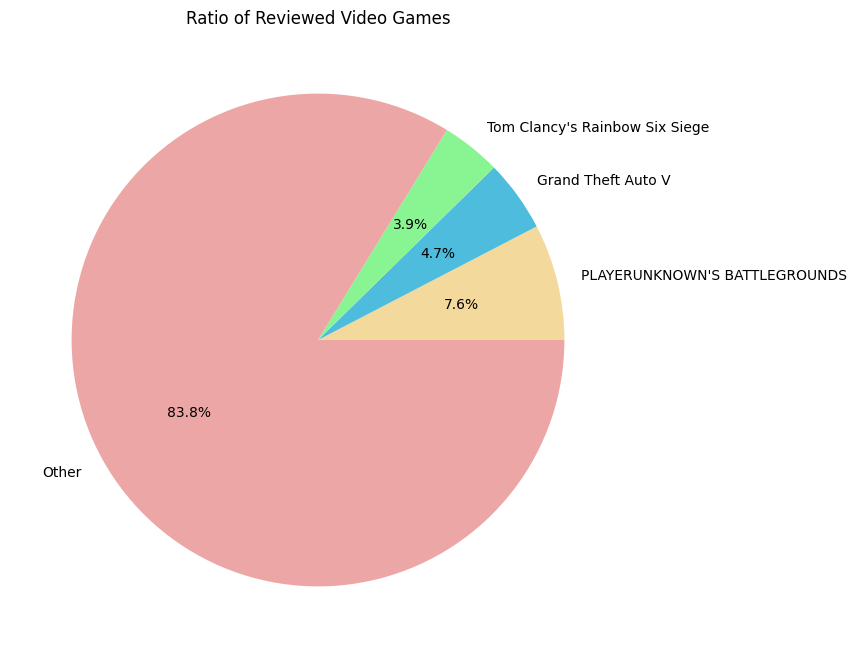

<Figure size 640x480 with 0 Axes>

In [9]:
review_cnts = df['app_name'].value_counts()
top_cnts = review_cnts.head(3)
others_cnts = review_cnts.iloc[3:].sum()

labels = list(top_cnts.index) + ['Other']
sizes = list(top_cnts.values) + [others_cnts]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#f3d99c', '#4ebcdd', '#89f592', '#eda6a6'])
plt.title('Ratio of Reviewed Video Games')

plt.show()
plt.clf()

The above pie chart shows the division of videogames that have been reviewed. **Playerunkown's Battlegrounds** is the most reviewed videogame in our dataset. This also highlights the player base for the video game as well as it's popularity, however no final judgment can be made until we know which video games are also the most recommended.

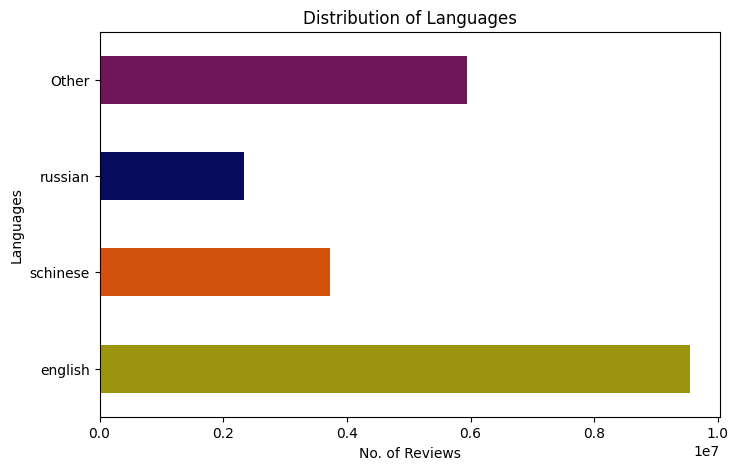

<Figure size 640x480 with 0 Axes>

In [10]:
lang_cnts = df['language'].value_counts()
top_cnts = lang_cnts.head(3)
other_cnts = lang_cnts[~lang_cnts.index.isin(top_cnts.index)].sum()
tot_cnts = pd.concat([top_cnts, pd.Series({'Other': other_cnts})])
plt.figure(figsize=(8, 5))

tot_cnts.plot(kind='barh', color=['#9c940e', '#d1510d', '#070b5e', '#701658'])
plt.title('Distribution of Languages')
plt.ylabel('Languages')
plt.xlabel('No. of Reviews')

plt.show()
plt.clf()

The above bar chart shows the languages the reviews are written in and it clearly shows a large no. of player base that are either natively speak english or prefer english as a language in the video game world.

#### *Univariate Analysis*

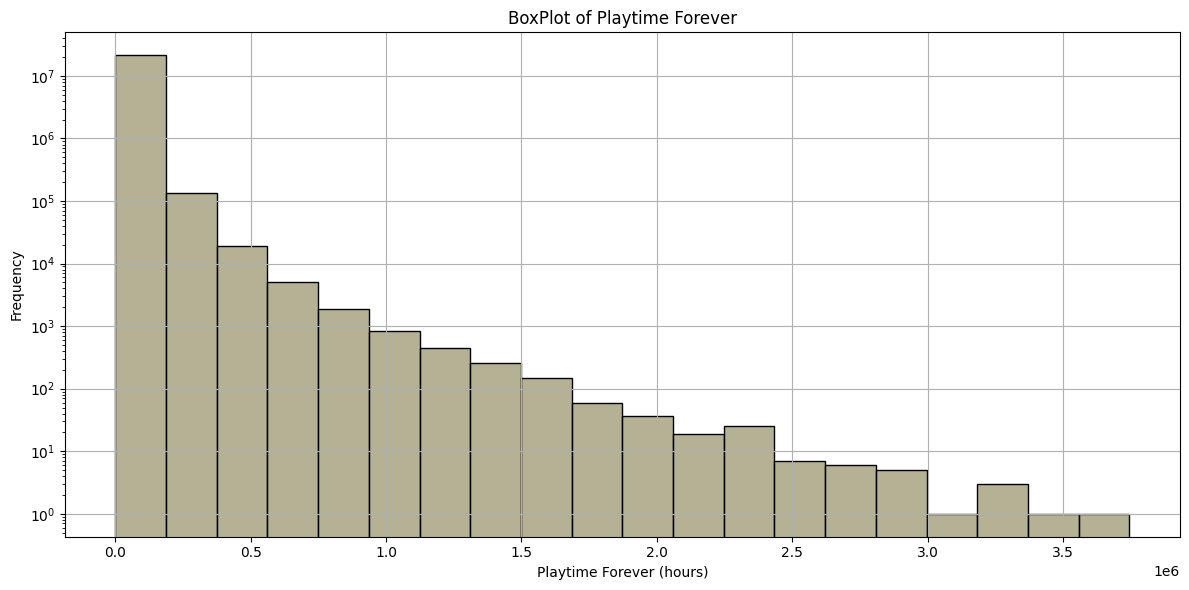

<Figure size 640x480 with 0 Axes>

In [11]:
plt.figure(figsize=(12, 6))
sns.histplot(df['author.playtime_forever'], bins=20, color='#9c9772', edgecolor='black', log=True)

plt.title('BoxPlot of Playtime Forever')
plt.xlabel('Playtime Forever (hours)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()

plt.show()
plt.clf()

The histogram shows us that there is a very high frequency of players who comparitively played the particular videogame for less no. of hours and reviewed that game. The histogram is almost right-skewed with a few complications as we move towards more no. of playtime hours.

#### *Bivariate Analysis*

<Figure size 2000x1500 with 0 Axes>

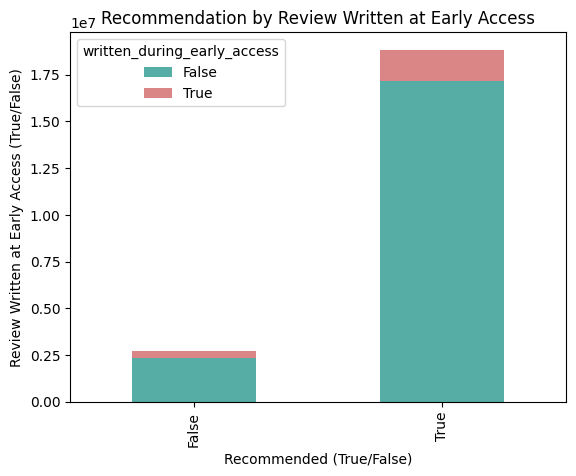

<Figure size 640x480 with 0 Axes>

In [12]:
plt.figure(figsize=(20,15))
pd.crosstab(df['recommended'], df['written_during_early_access']).plot(kind='bar', color=['#55ada5', '#db8686'], stacked=True)

plt.title('Recommendation by Review Written at Early Access')
plt.ylabel('Review Written at Early Access (True/False)')
plt.xlabel('Recommended (True/False)')

plt.show()
plt.clf()

The bar chart shows how likely are people to recommend a videogame based on whether they wrote the review during early access or after full release.  
We can see that more videogames are recommended after the full release rather than during early access. Moreover, same can be said if the videogame is not recommended.
However, comparison between video game being recommended whether it was reviewed in early access or full release is stark as compared to not being recommended under the same conditions.

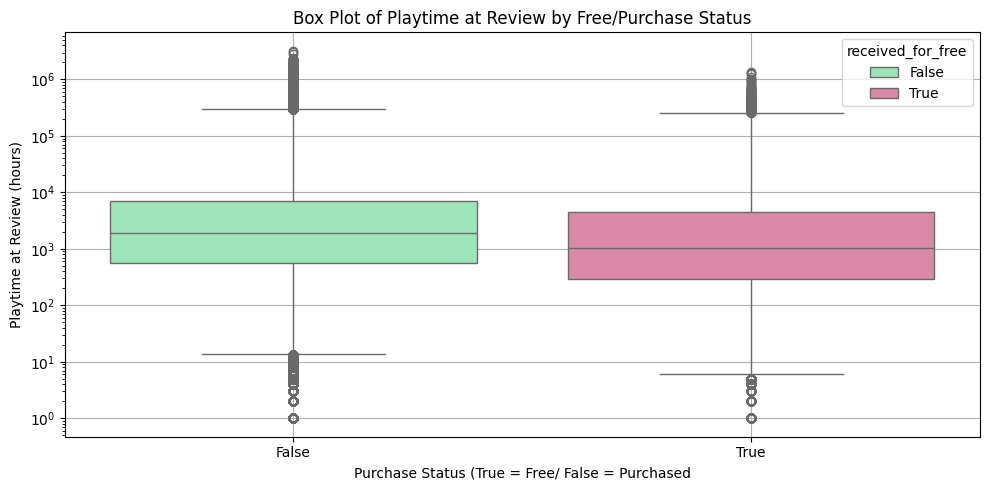

<Figure size 640x480 with 0 Axes>

In [13]:
plt.figure(figsize=(10,5))
sns.boxplot(x='received_for_free', y='author.playtime_at_review', data=df, hue='received_for_free', palette=['#92f0b6', '#e87ba5'], log_scale=True)

plt.title('Box Plot of Playtime at Review by Free/Purchase Status')
plt.ylabel('Playtime at Review (hours)')
plt.xlabel('Purchase Status (True = Free/ False = Purchased')
plt.grid(True)
plt.tight_layout()

plt.show()
plt.clf()

The boxplot indicates that videogames that are purchased (i.e. False) have had more playtime at review by the reviewing playerbase. Moreover, the interquantile range also apears to be higher along y-axis as compared to the interquantile range for videogames received for free. However, it must be noted that there are comparitively more upper and lower outliers for the purchased videogames as compared to the ones received for free.

#### *Timeseries Analysis*


Now let's take a look at some timeseries plots

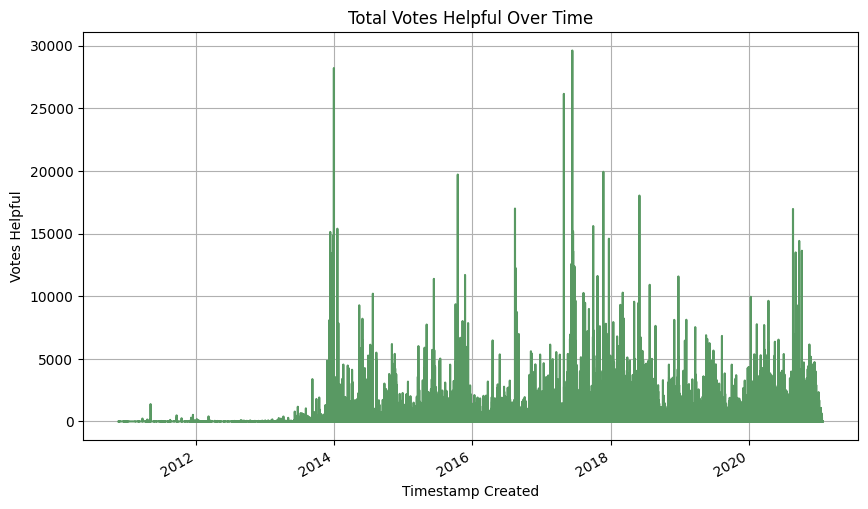

<Figure size 640x480 with 0 Axes>

In [14]:
plt.figure(figsize=(10, 6))
df.groupby('timestamp_created')['votes_helpful'].sum().plot(color='#599963')

plt.title('Total Votes Helpful Over Time')
plt.xlabel('Timestamp Created')
plt.ylabel('Votes Helpful')
plt.grid(True)

plt.show()
plt.clf()

The plot shows that more reviews have been voted helpful around 2014 and at an all time peak of about **3000** somewhere between **2017-18**.

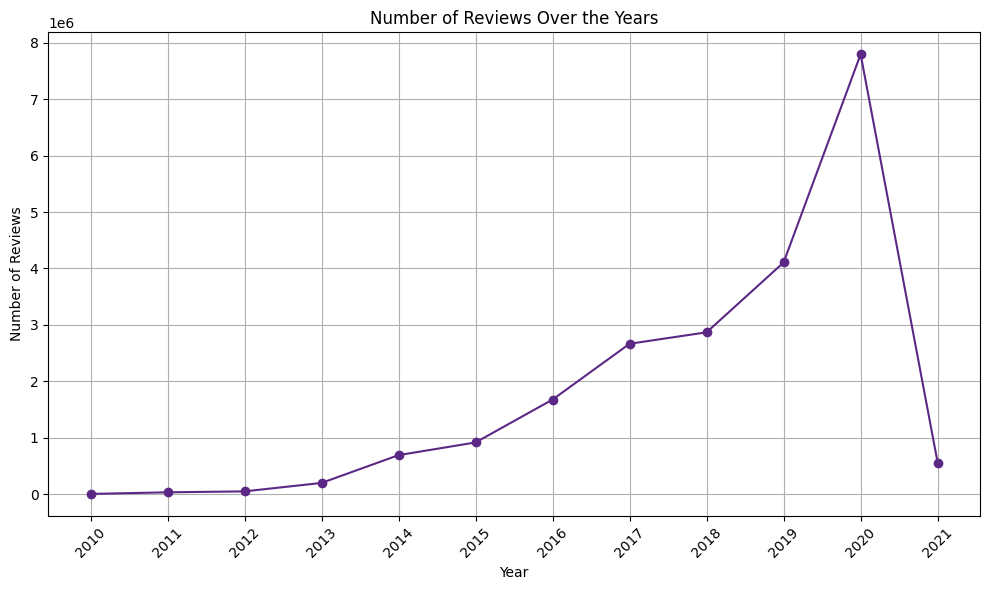

<Figure size 640x480 with 0 Axes>

In [15]:
plt.figure(figsize=(10, 6))
reviews_per_year = df.groupby(df['timestamp_created'].dt.year).size()
reviews_per_year.plot(kind='line', marker='o', color='#5c2885')

plt.title('Number of Reviews Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.xticks(reviews_per_year.index, rotation=45) 
plt.tight_layout()

plt.show()
plt.clf()

The line graph shows a gradual increase in the no. of reviews being done in successive years with an all time peak at the year **2020**. However, the graph shows an abrupt decline in the no. of reviews in the year 2021. We cannot anything with surety about this because the data might not contain data for all the months of the year 2021.

#### *Multivariate Analysis*

Now let's do multivariate analysis for three variables that might provide some interesting readings i.e. `recommended`, `weighted_vote_score` and `author.playtime_at_review`.

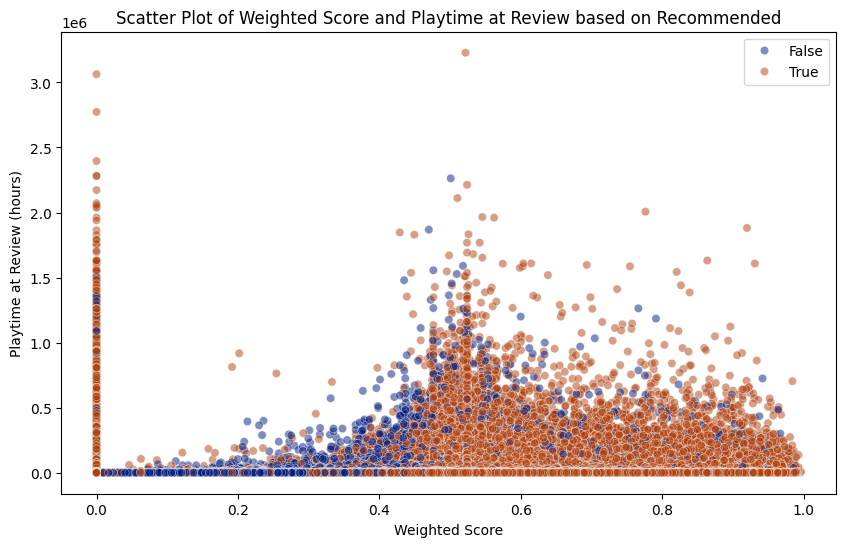

<Figure size 640x480 with 0 Axes>

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='weighted_vote_score', y='author.playtime_at_review', hue='recommended', palette="dark", alpha=0.5).legend(loc='upper right')

plt.title('Scatter Plot of Weighted Score and Playtime at Review based on Recommended')
plt.ylabel('Playtime at Review (hours)')
plt.xlabel('Weighted Score')

plt.show()
plt.clf()

By looking at this scatter plot, we can see that variable `recommended` is **TRUE** for lower values of the variable `author.playtime_at_review`. But it is indicated that the more `weighted_vote_score` a review has, it is more likely to be recommended. 
One nonconforming analysis that comes out of this plot is that if the weighted score is 0, the video game is recommended for almost any no. of playtime hours at the time of review.

#### *Correlation*

In [17]:
df_corr = df[['app_id','review_id', 'timestamp_created', 'timestamp_updated', 'recommended','votes_helpful', 'weighted_vote_score', 
              'comment_count', 'steam_purchase', 'received_for_free', 'written_during_early_access', 'author.steamid', 'author.num_reviews',
               'author.playtime_at_review', 'author.playtime_forever', 'author.last_played']].corr()
             
df_corr

,app_id,review_id,timestamp_created,timestamp_updated,recommended,votes_helpful,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_reviews,author.playtime_at_review,author.playtime_forever,author.last_played
app_id,1.000000,0.371416,0.375922,0.360993,-0.093094,0.003075,-0.027999,-0.005614,-0.008364,0.000381,0.157320,0.094355,-0.016656,-0.083013,-0.087889,0.209645
review_id,0.371416,1.000000,0.972929,0.938467,0.071810,-0.020428,-0.230143,-0.040961,0.073783,0.025942,-0.106491,0.445795,-0.073490,0.009969,-0.072750,0.556042
timestamp_created,0.375922,0.972929,1.000000,0.963913,0.048882,-0.019046,-0.210615,-0.039654,0.074386,0.033900,-0.106433,0.426264,-0.070400,0.023001,-0.053018,0.581851
timestamp_updated,0.360993,0.938467,0.963913,1.000000,0.042153,-0.017463,-0.195535,-0.033981,0.072505,0.032250,-0.117724,0.411895,-0.054495,0.060612,-0.019573,0.598973
recommended,-0.093094,0.071810,0.048882,0.042153,1.000000,-0.027440,-0.182600,-0.048736,-0.000597,0.007552,-0.049181,0.049154,-0.012824,-0.052383,-0.037443,0.090861
votes_helpful,0.003075,-0.020428,-0.019046,-0.017463,-0.027440,1.000000,0.108180,0.474899,-0.004225,-0.001961,0.004413,-0.017753,0.017838,0.006824,0.008548,-0.013704
weighted_vote_score,-0.027999,-0.230143,-0.210615,-0.195535,-0.182600,0.108180,1.000000,0.089079,-0.043052,0.008124,0.051459,-0.155353,0.099111,0.009645,0.046395,-0.110956
comment_count,-0.005614,-0.040961,-0.039654,-0.033981,-0.048736,0.474899,0.089079,1.000000,-0.006233,0.001842,0.007769,-0.026437,0.028283,0.013344,0.019143,-0.024288
steam_purchase,-0.008364,0.073783,0.074386,0.072505,-0.000597,-0.004225,-0.043052,-0.006233,1.000000,-0.127983,0.047909,0.100000,-0.041042,0.002726,0.010282,0.085564
received_for_free,0.000381,0.025942,0.033900,0.032250,0.007552,-0.001961,0.008124,0.001842,-0.127983,1.000000,-0.011424,0.067554,0.001350,-0.011891,-0.007106,0.015232


<Axes: >

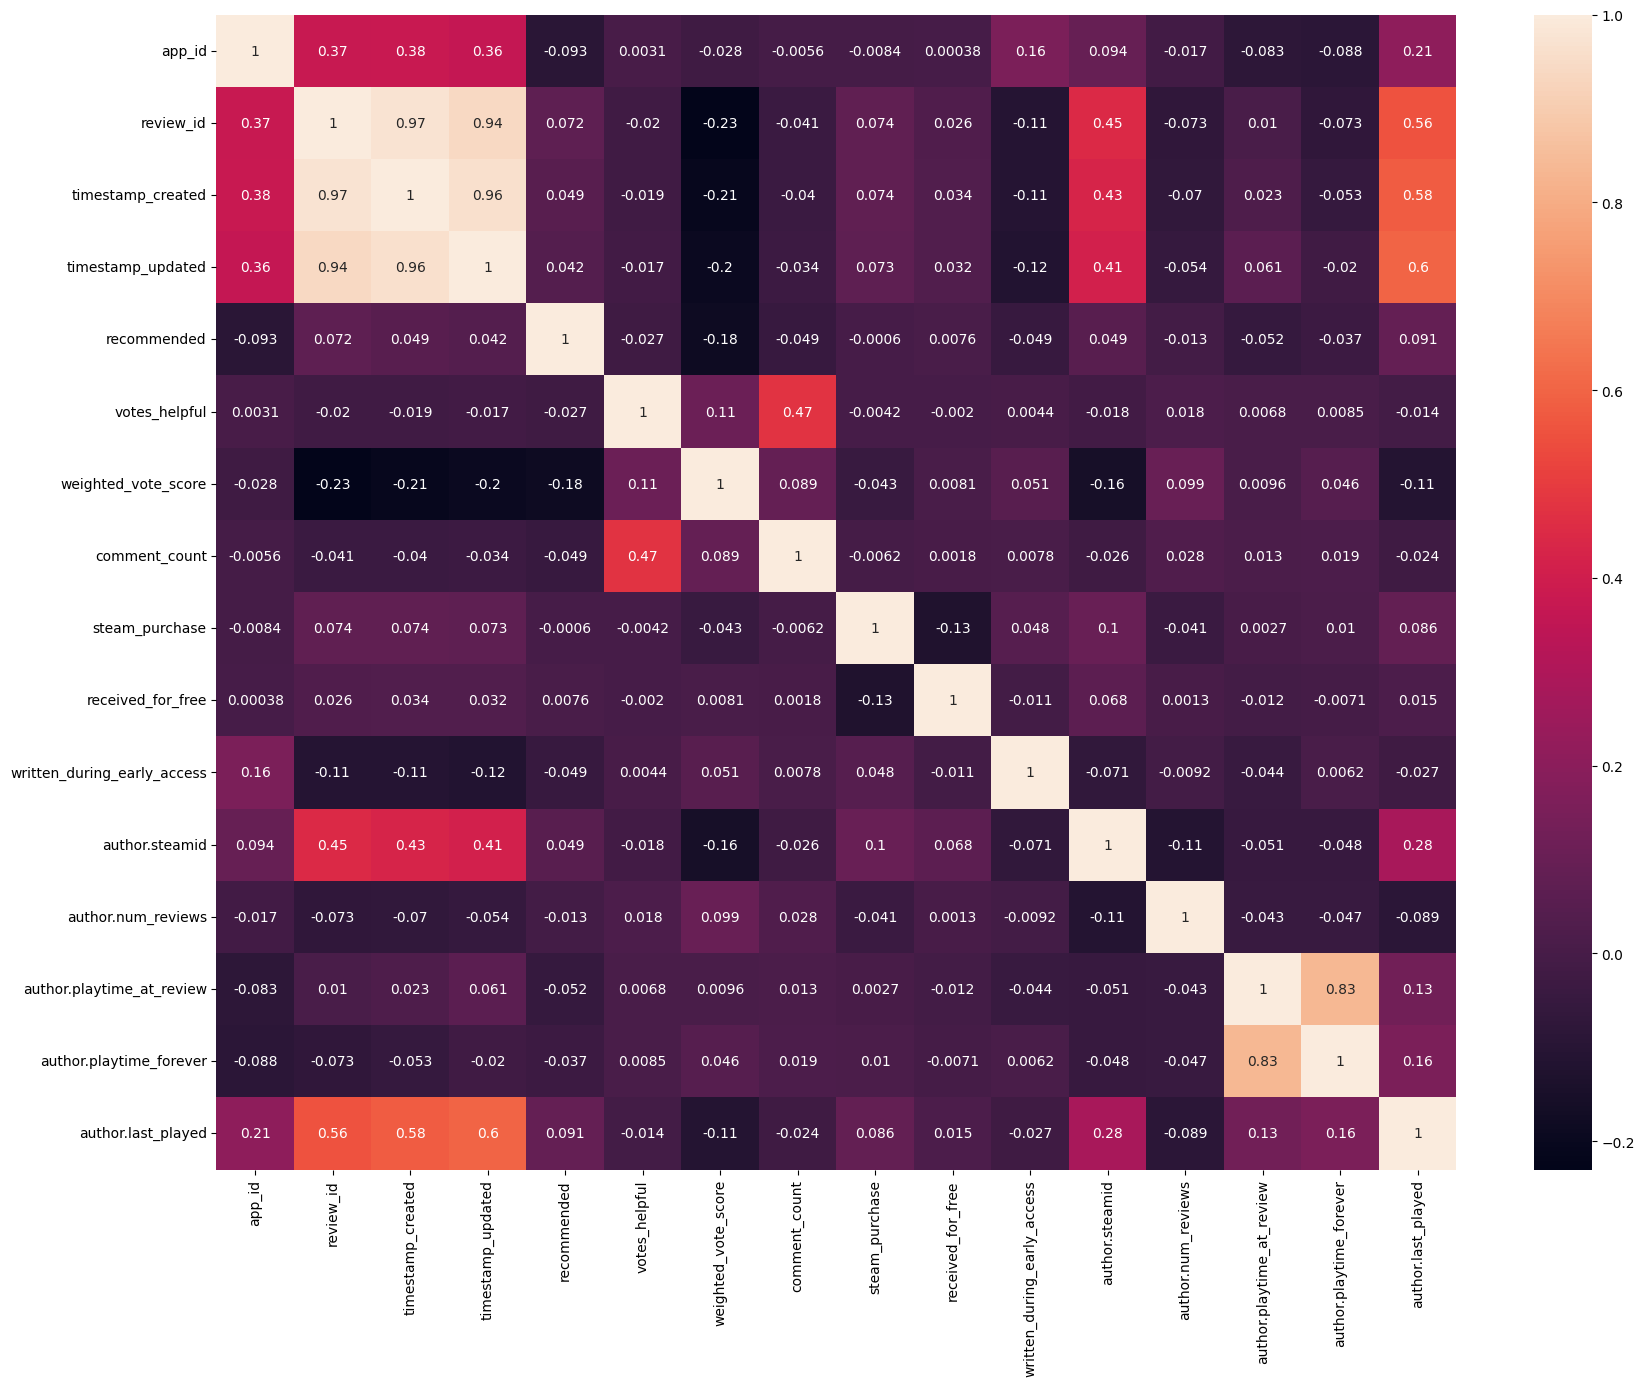

In [18]:
plt.subplots(figsize=(20,15))
sns.heatmap(df_corr, annot=True)

The correlation heatmap shows positive correlation between `review_id`, **timestamp** variables with `author.last_played` variables as well as `author.steamid`.  
Moreover, `comment_count` and `votes_helpful` also show a significant positive correlation of about **0.47**. Both the **playtime** variables show a slight negative correlation with the variable `recommended`.  
However, there seems to be not a very high correlation overall between the variables.